# NCC and Perceptron compared
Cognitive Algorithms        
Summer semester 2018      
Technische Universität Berlin     
Fachgebiet Maschinelles Lernen 

The linear Perceptron and the NCC are linear classification methods. Given training data
$$(\mathbf{x_1}, y_1),\ldots, ( \mathbf{x_n}, y_n ) \in \mathbb{R}^d \times \{-1,1\}$$
their goal is to learn a weight vector $\mathbf{w}$ and a bias term $b$, such that each new data point $\mathbf{x} \in \mathbb{R}^d$ will be assigned the correct class label via the following function:
$$\mathbf x \mapsto  \mbox{sign}(\mathbf w^T \cdot \mathbf x - b)$$


The two methods use different strategies to achieve this goal.
The following script compares the perceptron and the prototype classifier and usees them to predict handwritten digits. The task is to classify one digit against all others.

In [1]:
import scipy as sp
import scipy.io as io
import pylab as pl
%matplotlib inline

In [2]:
''' ---- Functions for loading and plotting the images ---- '''
def load_usps_data(fname, digit=3):
    ''' Loads USPS (United State Postal Service) data from <fname> 
    Definition:  X, Y = load_usps_data(fname, digit = 3)
    Input:       fname   - string
                 digit   - optional, integer between 0 and 9, default is 3
    Output:      X       -  DxN array with N images with D pixels
                 Y       -  1D array of length N of class labels
                                 1 - where picture contains the <digit>
                                -1 - otherwise                           
    '''
    # load the data
    data = io.loadmat(fname)
    # extract images and labels
    X = data['data_patterns']
    Y = data['data_labels']
    Y = Y[digit,:]
    return X, Y

def plot_img(a):
    ''' Plots one image 
    Definition: plot_img(a) 
    Input:      a - 1D array that contains an image 
    '''   
    a2 = sp.reshape(a,(int(sp.sqrt(a.shape[0])), int(sp.sqrt(a.shape[0]))))
    pl.imshow(a2, cmap='gray') 
    pl.colorbar()
    pl.setp(pl.gca(), xticks=[], yticks=[])
            
# def plot_imgs(X, Y):   
#     ''' Plots 3 images from each of the two classes 
#     Definition:         plot_imgs(X,Y)
#     Input:       X       -  DxN array of N pictures with D pixel
#                  Y       -  1D array of length N of class labels {1, -1}                  
#     '''
#     pl.figure()
#     for i in sp.arange(3):
#         classpos = (Y == 1).nonzero()[0]
#         m = classpos[sp.random.random_integers(0, classpos.shape[0]-1)]
#         pl.subplot(2,3,1+i)
#         plot_img(X[:, m])
#     for i in sp.arange(3):
#         classneg = (Y != 1).nonzero()[0]
#         m = classneg[sp.random.random_integers(0, classneg.shape[0]-1)]
#         pl.subplot(2,3,4+i)
#         plot_img(X[:, m])

```train_perceptron``` implements the Perceptron algorithm. We test three different types of update rules for the learning rate (```option``` $\in \{0,1,2\}$).
$$\text{learning rate}(t) = \begin{cases} \frac{\eta}{1+t} & \text{if} \;\; \text{option} = 0  \\ \eta & \text{if} \;\; \text{option} = 1 \\ \eta \cdot (1+t) & \text{if} \;\; \text{option} = 3 \end{cases}$$
where $t$ is the current iteration and $\eta$ the initial value of the learning rate.           

In [3]:
def train_perceptron(X,Y,iterations=200,eta=.1, option=0):
    ''' Trains a linear perceptron
    Definition:  w, b, acc  = train_perceptron(X,Y,iterations=200,eta=.1)
    Input:       X       -  DxN array of N data points with D features
                 Y       -  1D array of length N of class labels {-1, 1}
                 iter    -  optional, number of iterations, default 200
                 eta     -  optional, learning rate, default 0.1
                 option  -  optional, defines how eta is updated in each iteration
    Output:      w       -  1D array of length D, weight vector 
                 b       -  bias term for linear classification                          
                 acc     -  1D array of length iter, contains classification accuracies 
                            after each iteration  
                            Accuracy = #correctly classified points / N 
    '''
    assert option == 0 or option == 1 or option == 2
    acc = sp.zeros((iterations))
    #include the bias term by adding a row of ones to X 
    X = sp.concatenate((sp.ones((1,X.shape[1])), X))
    #initialize weight vector
    weights = sp.ones((X.shape[0]))/X.shape[0]
    for it in sp.arange(iterations):
        # indices of misclassified data
        wrong = (sp.sign(weights.dot(X)) != Y).nonzero()[0]
        # compute accuracy acc[it]
        acc[it] = (X.shape[1] - wrong.shape[0]) / X.shape[1]
        if wrong.shape[0] > 0:
            # pick a random misclassified data point
            rndi = sp.random.choice(wrong)# get random index from wrong
            x = X[:,rndi] # image - do not transpose (tested)
            y = Y[rndi] # label
            if option == 0:
                weights += (eta / (1+it)) * x * y
            elif option == 1:
                weights += eta * x * y
            elif option == 2:
                weights += (eta * (1 + it)) * x * y
    b = -weights[0] 
    w = weights[1:]
    #return weight vector, bias and accuracies
    return w,b,acc

''' --------------------------------------------------------------------------------- '''
def analyse_accuracies_perceptron(digit = 3, option=0):
    ''' Loads usps.mat data and plots digit recognition accuracy in the linear perceptron
    Definition: analyse_perceptron(digit = 3)
    '''
    X,Y = load_usps_data('usps.mat',digit)
    w_per,b_per,acc = train_perceptron(X,Y, option=option)
    
    pl.figure()
    pl.plot(sp.arange(len(acc)),acc)
    pl.title('Digit recognition accuracy')      
    pl.xlabel('Iterations')
    pl.ylabel('Accuracy')

```analyse_accuracies_perceptron``` plots the classification accuracy, i.e. the percentage of correctly classified data points, as a function of iterations.

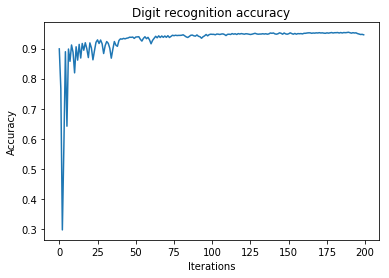

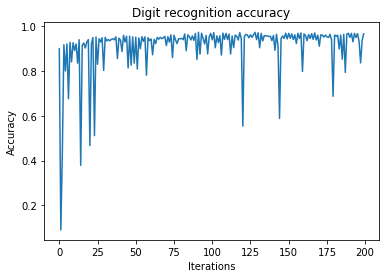

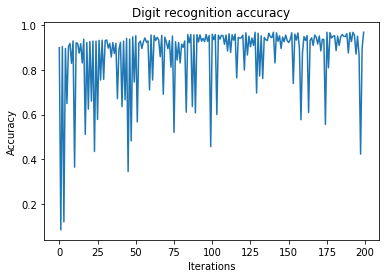

In [4]:
analyse_accuracies_perceptron(digit=3, option=0)
analyse_accuracies_perceptron(digit=3, option=1)
analyse_accuracies_perceptron(digit=3, option=2)

The following method ```train_ncc``` implements a Prototype/Nearest Centroid Classifier.

In [5]:
def train_ncc(X,Y):
    ''' Trains a prototype/nearest centroid classifier
    Definition:  w, b   = train_ncc(X,Y)
    Input:       X       -  DxN array of N data points with D features
                 Y       -  1D array of length N of class labels {-1, 1}
    Output:      w       -  1D array of length D, weight vector  
                 b       -  bias term for linear classification                          
    '''
    # ... your code here 
    #positive classifier = positive means
    wp = X[:,(Y>0)]
    #negative classifier = negative means
    wn = X[:,(Y<0)]
    wp = sp.mean(X.T[(Y>0)],0)
    wn = sp.mean(X.T[(Y<0)],0)
    w = wp - wn
    #bias
    b = (sp.dot(wp,wp) - sp.dot(wn,wn)) / 2
    return w, b

In [11]:
def plot_histogram(X, Y, w, b):
    ''' Plots a histogram of classifier outputs (w^T X) for each class with pl.hist 
    The title of the histogram is the accuracy of the classification
    Accuracy = #correctly classified points / N 
    
    Definition:     plot_histogram(X, Y, w, b)
    Input:          X       -  DxN array of N data points with D features
                    Y       -  1D array of length N of class labels
                    w       -  1D array of length D, weight vector 
                    b       -  bias term for linear classification   
    
    '''
    #Plot histogram
    pl.hist((w.dot(X[:,Y<0]), w.dot(X[:,Y>0])))
    pl.xlabel("w^T X") 
    pl.legend(("non-target","target"))
    #Title contains the accuracy
    pl.title("Acc " + str(100*sp.sum(sp.sign(w.dot(X)-b)==Y)/X.shape[1]) + "%")  
    
''' --------------------------------------------------------------------------------- '''
def compare_classifiers(digit = 3):
    ''' Loads usps.mat data, trains the perceptron and the Nearest centroid classifiers, 
    and plots their weight vector and classifier output
    Definition: compare_classifiers(digit = 3)
    '''
    X,Y = load_usps_data('usps.mat',digit)
    w_ncc,b_ncc = train_ncc(X,Y)
    w_per,b_per,_ = train_perceptron(X,Y)
    
    fig = pl.figure()
    pl.subplot(2,2,1)
    plot_img(w_ncc)
    pl.title('NCC')
    pl.subplot(2,2,3)
    plot_histogram(X, Y, w_ncc, b_ncc)
    
    pl.subplot(2,2,2)
    plot_img(w_per)
    pl.title('Perceptron')
    pl.subplot(2,2,4)
    plot_histogram(X, Y, w_per, b_per)
    
    # this will save the plot to a pdf
#     fig.savefig("compare_digit_{}.pdf".format(digit), bbox_inches='tight')

We can compare both ML algorithms by calling ```compare_classifiers``` for a digit of our choice. It plots, for both the perceptron and the nearest centroid classifier, the histogram of classifier outputs and the weight vector.                       
             
*Hint: The function ```plot_histogram``` calculates the classification accuracy and plots a histogram of classifier output $\mathbf w^T \mathbf x$ for each class. To do so, $X$ is sorted according to their labels and $w^T x$ is computed for each class. The accuracy of the algorithm is printed as the title of the plot.*

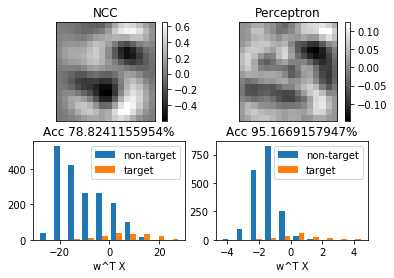

In [14]:
# compare a digit of choice
# compare_classifiers(digit=0)
# compare_classifiers(digit=1)
# compare_classifiers(digit=2)
# compare_classifiers(digit=3)
# compare_classifiers(digit=4)
compare_classifiers(digit=5)
# compare_classifiers(digit=6)
# compare_classifiers(digit=7)
# compare_classifiers(digit=8)
# compare_classifiers(digit=9)